In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import timedelta

In [3]:
path_data = '../data/data combined (aqcin)/combined aqicn data (all german cities).csv'

In [4]:
df_data_all_cities = pd.read_csv(path_data)

In [5]:
df_data = df_data_all_cities.copy()

In [6]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_data.sort_values(by='date', ascending=True, inplace=True)
df_data.rename(columns={' pm10':'pm10', ' pm25':'pm25'}, inplace=True)
df_data.replace(' ', np.nan, inplace=True) 
df_data['pm10'] = pd.to_numeric(df_data['pm10']) # , downcast='float'
df_data['pm25'] = pd.to_numeric(df_data['pm25']) # , downcast='float'
df_data.replace({'munich':'Munich','berlin,-germany':'Berlin',
            'potsdam-zentrum,-germany':'Potsdam',
            'hannover,-germany':'Hannover',
            'stuttgart-bad-cannstatt, germany':'Stuttgart',
            'dresden-bergstraße,-germany':'Dresden',
            'sternschanze,-hamburg, germany':'Hamburg',
            'frankfurt-schwanheim,-germany':'Frankfurt',
            'kiel-bahnhofstr.-verk., schleswig-holstein, germany':'Kiel'}, inplace=True )

In [7]:
# drop nan values
df_data.dropna(axis = 0, inplace = True)

In [8]:
df_data.isnull().sum()

date    0
city    0
pm25    0
pm10    0
dtype: int64

In [9]:
df_data.columns

Index(['date', 'city', 'pm25', 'pm10'], dtype='object')

In [10]:
# convert string columns into numeric 
df_data['pm25'] = pd.to_numeric(df_data['pm25'], errors='coerce')
df_data['pm10'] = pd.to_numeric(df_data['pm10'], errors='coerce')

In [11]:
df_data

,date,city,pm25,pm10
15,2014-08-19,Hamburg,21.0,9.0
21,2014-08-20,Hamburg,15.0,9.0
27,2014-08-21,Hamburg,25.0,15.0
30,2014-08-22,Hamburg,47.0,14.0
43,2014-08-23,Hamburg,46.0,10.0
...,...,...,...,...
26805,2023-12-27,Kiel,20.0,9.0
26807,2023-12-27,Hamburg,23.0,9.0
26803,2023-12-27,Dresden,34.0,10.0
26802,2023-12-27,Munich,42.0,14.0


In [12]:
df_data.reset_index(drop = True, inplace = True)

In [13]:
# Function to create lag features for time series data
def create_lag_features(df, target_column, lag):
    if target_column not in df.columns:
        raise KeyError(f"Target column '{target_column}' not found in the DataFrame.")
    
    df_copy = df.copy()
    for i in range(1, lag + 1):
        df_copy[f"{target_column}_lag_{i}"] = df_copy[target_column].shift(i)
    return df_copy.dropna(subset=[f"{target_column}_lag_{lag}"])

In [14]:
# Create lag features
lag = 3  # the lag can be adjusted as needed
df_data_lagged = create_lag_features(df_data, 'pm25', lag)

In [15]:
df_data_lagged

,date,city,pm25,pm10,pm25_lag_1,pm25_lag_2,pm25_lag_3
3,2014-08-22,Hamburg,47.0,14.0,25.0,15.0,21.0
4,2014-08-23,Hamburg,46.0,10.0,47.0,25.0,15.0
5,2014-08-24,Hamburg,31.0,8.0,46.0,47.0,25.0
6,2014-08-25,Hamburg,25.0,11.0,31.0,46.0,47.0
7,2014-08-26,Hamburg,26.0,13.0,25.0,31.0,46.0
...,...,...,...,...,...,...,...
12796,2023-12-27,Kiel,20.0,9.0,26.0,18.0,43.0
12797,2023-12-27,Hamburg,23.0,9.0,20.0,26.0,18.0
12798,2023-12-27,Dresden,34.0,10.0,23.0,20.0,26.0
12799,2023-12-27,Munich,42.0,14.0,34.0,23.0,20.0


In [16]:
df_data_lagged.reset_index(drop = True, inplace = True)

In [17]:
len(df_data_lagged)

12798

In [18]:
# Define features and target
features = [col for col in df_data_lagged.columns if col not in ['date', 'city', 'pm25', 'pm10']]
target_pm25 = 'pm25'
target_pm10 = 'pm10'

In [19]:
# Train-test split (80-20 split)
train_size = int(0.8 * len(df_data_lagged))
train_data, test_data = df_data_lagged.iloc[:train_size], df_data_lagged.iloc[train_size:]

In [20]:
# Function to perform grid search and return the best model
def grid_search_model(model, param_grid, features, target):
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)
    grid_search.fit(train_data[features], train_data[target])
    best_model = grid_search.best_estimator_
    return best_model

In [21]:
target_pm25

'pm25'

In [22]:
features

['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']

In [23]:
%%time
# Hyperparameter tuning for Lasso Regression
lasso_param_grid = {'alpha': [0.01, 0.1, 1, 10]}
lasso_best = grid_search_model(Lasso(), lasso_param_grid, features, target_pm25)

CPU times: total: 46.9 ms
Wall time: 116 ms


In [24]:
%%time
# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
gb_best = grid_search_model(GradientBoostingRegressor(), gb_param_grid, features, target_pm25)

CPU times: total: 22.6 s
Wall time: 43.5 s


In [25]:
%%time
# Hyperparameter tuning for XGBoost
xgb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
xgb_best = grid_search_model(XGBRegressor(), xgb_param_grid, features, target_pm25)

CPU times: total: 1min 23s
Wall time: 8.45 s


In [26]:
%%time
# Hyperparameter tuning for Support Vector Regression (SVR)
svr_param_grid = {'C': [0.01, 0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]}
svr_best = grid_search_model(SVR(), svr_param_grid, features, target_pm25)

CPU times: total: 38.7 s
Wall time: 1min 17s


In [27]:
# Stack models using StackingRegressor
stacked_model = StackingRegressor(estimators=[('lasso', lasso_best), ('gb', gb_best), ('xgb', xgb_best), ('svr', svr_best)])
stacked_model.fit(train_data[features], train_data[target_pm25])

StackingRegressor(estimators=[('lasso', Lasso(alpha=10)),
                              ('gb',
                               GradientBoostingRegressor(n_estimators=50)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gr...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('svr', SVR(C=1, epsilon=0.2))])

In [28]:
# Make predictions on the test set
test_predictions = stacked_model.predict(test_data[features])

In [29]:
# Evaluate performance
mse = mean_squared_error(test_data[target_pm25], test_predictions)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 192.1046387554074


In [30]:
# Choose the city for visualization
selected_city = 'Berlin'  # Change this to the desired city

In [31]:
# Filter test set data for the selected city
test_data_city = test_data[test_data['city'] == selected_city]

In [32]:
# Make predictions using the stacked model
predictions_city = stacked_model.predict(test_data_city[features])

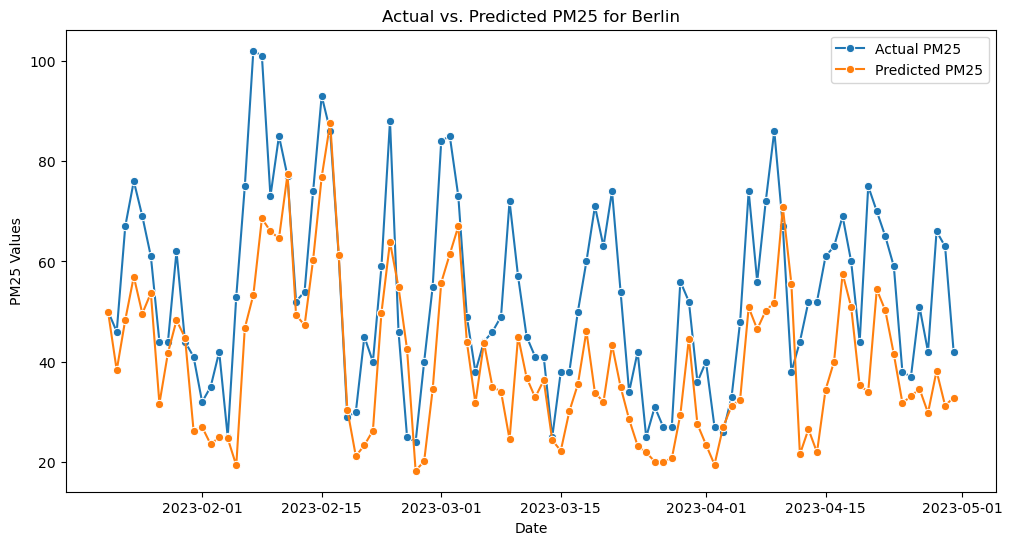

In [35]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data_city['date'][:100], y=test_data_city['pm25'][:100], label='Actual PM25', marker='o')
sns.lineplot(x=test_data_city['date'][:100], y=predictions_city[:100], label='Predicted PM25', marker='o')
plt.title(f'Actual vs. Predicted PM25 for {selected_city}')
plt.xlabel('Date')
plt.ylabel('PM25 Values')
plt.legend()
plt.show()

In [39]:
# Choose the city and number of days for forecasting
forecast_city = input("Enter the city for forecasting: ")
forecast_days = int(input("Enter the number of days into the future for forecasting: "))

Enter the city for forecasting: Munich
Enter the number of days into the future for forecasting: 365


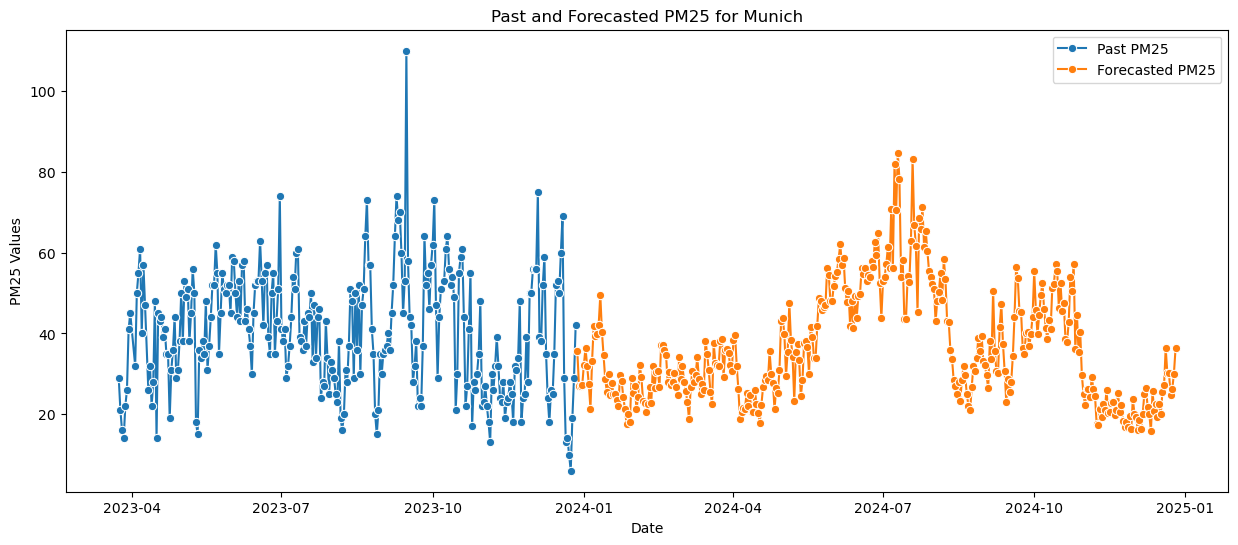

In [40]:
# Filter the complete data for the selected city
complete_data_city = df_data[df_data['city'] == forecast_city]

# Identify the last date in the complete data
last_date = complete_data_city['date'].max()

# Create future dates for forecasting
future_dates = pd.date_range(last_date + timedelta(days=1), periods=forecast_days, freq='D')

# Create features for the future dates (lagged features)
future_features = create_lag_features(pd.DataFrame({'date': future_dates, 'pm25': np.nan}), 'pm25', lag=lag).drop(columns=['date'])

# Initialize or ensure 'features' list exists
features = features if 'features' in locals() else []

# Include lagged features in the 'features' list without duplicates
features += [f"pm25_lag_{i}" for i in range(1, lag + 1) if f"pm25_lag_{i}" not in features]

# Combine past and future features
all_features = pd.concat([df_data_lagged[features], future_features[features]], ignore_index=True)

# Make predictions for both past and future using the stacked model
all_predictions = stacked_model.predict(all_features)

# Plot past and forecasted values
plt.figure(figsize=(15, 6))
sns.lineplot(x=complete_data_city['date'], y=complete_data_city['pm25'], label='Past PM25', marker='o')
sns.lineplot(x=pd.date_range(last_date + timedelta(days=1), periods=forecast_days, freq='D'), y=all_predictions[-forecast_days:], label='Forecasted PM25', marker='o')

plt.title(f'Past and Forecasted PM25 for {forecast_city}')
plt.xlabel('Date')
plt.ylabel('PM25 Values')
plt.legend()
plt.show()